In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2023-09-28 12:54:09.362056: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 12:54:09.415611: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-28 12:54:09.417457: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 12:54:10.382489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillageCombined1000-2 - Copy/Train/",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 11814 files belonging to 13 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Black_mold',
 'Tomato__Gray_spot',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato__powdery_mildew',
 'Tomato_healthy']

In [5]:
len(dataset)

370

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.9, val_split=0.1, test_split=0.0, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [10]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [11]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
base_model = tf.keras.applications.ResNet152(weights = 'imagenet', include_top = False, input_shape = (224,224,3))


In [14]:
len(base_model.layers)

fine_tune_at = 400

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [15]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(13, activation = 'softmax')(x)

In [16]:
from tensorflow.keras import losses, Model

head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])





In [17]:
resnet_classifier = head_model.fit(train_ds,
epochs = 20,
validation_data=val_ds,
batch_size = BATCH_SIZE,
verbose = 1)

Epoch 1/20
333/333 [==============================] - 1044s 3s/step - loss: 2.0824 - accuracy: 0.6604 - val_loss: 0.6492 - val_accuracy: 0.7945
Epoch 2/20
333/333 [==============================] - 1016s 3s/step - loss: 0.3217 - accuracy: 0.8917 - val_loss: 1.1668 - val_accuracy: 0.8359
Epoch 3/20
333/333 [==============================] - 1008s 3s/step - loss: 0.2141 - accuracy: 0.9351 - val_loss: 7.5587 - val_accuracy: 0.5354
Epoch 4/20
333/333 [==============================] - 1008s 3s/step - loss: 0.1645 - accuracy: 0.9467 - val_loss: 0.4272 - val_accuracy: 0.8903
Epoch 5/20
333/333 [==============================] - 999s 3s/step - loss: 0.1316 - accuracy: 0.9561 - val_loss: 0.1273 - val_accuracy: 0.9585
Epoch 6/20
333/333 [==============================] - 1003s 3s/step - loss: 0.1006 - accuracy: 0.9678 - val_loss: 0.0798 - val_accuracy: 0.9758
Epoch 7/20
333/333 [==============================] - 1002s 3s/step - loss: 0.1148 - accuracy: 0.9674 - val_loss: 0.2268 - val_accuracy: 

In [18]:
# head_model.save("PlantVillageCombined1000-2 - Copy/ResNet/")

In [19]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillageCombined1000-2 - Copy/Test/",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 1404 files belonging to 13 classes.


In [23]:
scores = head_model.evaluate(test_ds)

44/44 [==============================] - 66s 1s/step - loss: 1.1879 - accuracy: 0.8768


In [28]:
resnet_classifier.history

{'loss': [2.082425355911255,
  0.3216739296913147,
  0.21414536237716675,
  0.16446800529956818,
  0.13164983689785004,
  0.10062594711780548,
  0.11482467502355576,
  0.16043227910995483,
  0.10283412039279938,
  0.07899773120880127,
  0.06729461997747421,
  0.12546367943286896,
  0.08801160752773285,
  0.0978231206536293,
  0.07373685389757156,
  0.04713255167007446,
  0.04183611273765564,
  0.03603775054216385,
  0.0601821094751358,
  0.1112232580780983],
 'accuracy': [0.660395085811615,
  0.8917215466499329,
  0.9350893497467041,
  0.9466603994369507,
  0.9560677409172058,
  0.9678269028663635,
  0.9673565626144409,
  0.9555032849311829,
  0.9679209589958191,
  0.9759172201156616,
  0.9800564646720886,
  0.9674506187438965,
  0.9762935042381287,
  0.9741297960281372,
  0.9809972047805786,
  0.9846660494804382,
  0.9878645539283752,
  0.9885230660438538,
  0.9849482774734497,
  0.9717779755592346],
 'val_loss': [0.64924556016922,
  1.1667708158493042,
  7.558653831481934,
  0.427201

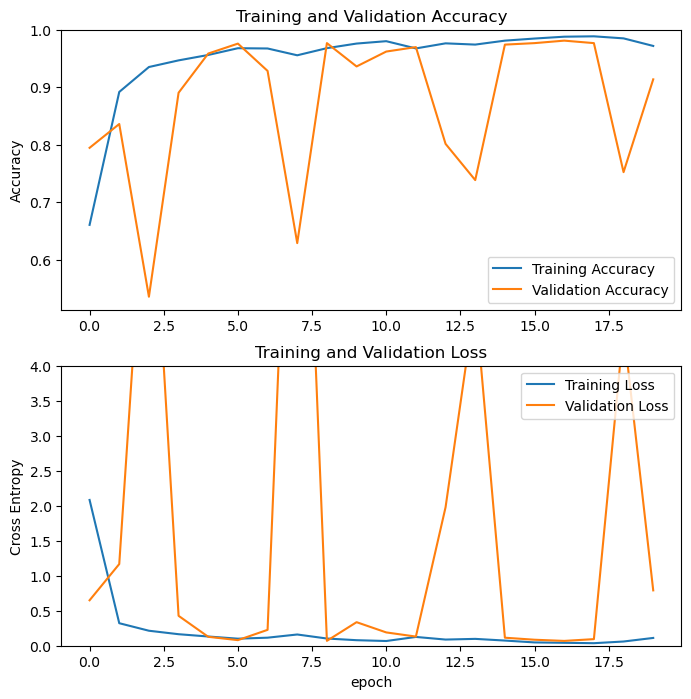

In [29]:
acc = resnet_classifier.history['accuracy']
val_acc = resnet_classifier.history['val_accuracy']

loss = resnet_classifier.history['loss']
val_loss = resnet_classifier.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()